In [139]:
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt

In [179]:
model = pyo.AbstractModel()

model.n = pyo.Param(within=pyo.NonNegativeIntegers)
model.I = pyo.RangeSet(1, model.n)

model.m = pyo.Param(within=pyo.NonNegativeIntegers)
model.J = pyo.RangeSet(1, model.m)

model.X = pyo.Param(model.I, domain=pyo.Reals)
model.Y = pyo.Param(model.I, domain=pyo.Reals)

# B[i,j] indicates that point i is in segment s <= j
model.B = pyo.Var(model.I, model.J, domain=pyo.Binary)
# deviation
model.d = pyo.Var(model.I, domain=pyo.NonNegativeReals)
# y = kx + b
model.k = pyo.Var(model.J, domain=pyo.Reals)
model.b = pyo.Var(model.J)

In [180]:
def obj_expression(m):
    return pyo.summation(m.d)

model.OBJ = pyo.Objective(rule=obj_expression)

def fillLastRule(m, i):
    return (m.B[i,m.m] == 1)

model.fillLastConst = pyo.Constraint(model.I, rule = fillLastRule)

def fillOneRule(m, j):
    return (m.B[1,j] == 1)

model.fillOneConst = pyo.Constraint(model.J, rule = fillOneRule)

def includesLastRule(m, i, j):
    return (m.B[i,j] >= m.B[i,j-1])

J2 = pyo.RangeSet(2, model.m)
model.inclLastConst = pyo.Constraint(model.I, J2, rule = includesLastRule)

def solidRule(m, i, j):
    return (m.B[i,j] <= m.B[i-1,j])

I2 = pyo.RangeSet(2, model.n)
model.solidConst = pyo.Constraint(I2, model.J, rule = solidRule)

bigM = 1000

def devPosRule(m, i, j):
    return (-bigM * (1 - m.B[i, j] + m.B[i,j-1]) + m.X[i]*m.k[j] + m.b[j] - m.Y[i] <= m.d[i])

model.devPosConst = pyo.Constraint(model.I, J2, rule = devPosRule)

def devPosFirstRule(m, i):
    return (-bigM * (1 - m.B[i, 1]) + m.X[i]*m.k[1] + m.b[1] - m.Y[i] <= m.d[i])

model.devPosFirstConst = pyo.Constraint(model.I, rule = devPosFirstRule)

def devNegRule(m, i, j):
    return (-bigM * (1 - m.B[i, j] + m.B[i,j-1]) - m.X[i]*m.k[j] - m.b[j] + m.Y[i] <= m.d[i])

model.devNegConst = pyo.Constraint(model.I, J2, rule=devNegRule)

def devNegFirstRule(m, i):
    return (-bigM * (1 - m.B[i, 1]) - m.X[i]*m.k[1] - m.b[1] + m.Y[i] <= m.d[i])

model.devNegFirstConst = pyo.Constraint(model.I, rule = devNegFirstRule)

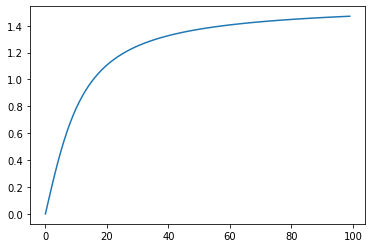

In [181]:
X = np.arange(100)
y = np.arctan(X / 10)
plt.plot(X, y)

In [182]:
params = dict()
params['n'] = {None : X.shape[0]}
params['m'] = {None : 4}
Xlist = X.tolist()
params['X'] = {i+1 : Xlist[i] for i in range(len(Xlist))}
ylist = y.tolist()
params['Y'] = {i+1 : ylist[i] for i in range(len(ylist))}
params = {None : params}

In [183]:
instance = model.create_instance(params)

In [184]:
instance.write('instance.gams')

('instance.gams', 2526694880448)

In [185]:
instance.pprint()

5 Set Declarations
    B_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    I*J :  400 : {(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4), (5, 1), (5, 2), (5, 3), (5, 4), (6, 1), (6, 2), (6, 3), (6, 4), (7, 1), (7, 2), (7, 3), (7, 4), (8, 1), (8, 2), (8, 3), (8, 4), (9, 1), (9, 2), (9, 3), (9, 4), (10, 1), (10, 2), (10, 3), (10, 4), (11, 1), (11, 2), (11, 3), (11, 4), (12, 1), (12, 2), (12, 3), (12, 4), (13, 1), (13, 2), (13, 3), (13, 4), (14, 1), (14, 2), (14, 3), (14, 4), (15, 1), (15, 2), (15, 3), (15, 4), (16, 1), (16, 2), (16, 3), (16, 4), (17, 1), (17, 2), (17, 3), (17, 4), (18, 1), (18, 2), (18, 3), (18, 4), (19, 1), (19, 2), (19, 3), (19, 4), (20, 1), (20, 2), (20, 3), (20, 4), (21, 1), (21, 2), (21, 3), (21, 4), (22, 1), (22, 2), (22, 3), (22, 4), (23, 1), (23, 2), (23, 3), (23, 4), (24, 1), (24, 2), (24, 3), (24, 4), (25, 1), (25, 2), (

In [186]:
opt = pyo.SolverFactory('glpk')
solution = opt.solve(instance, tee=True)

GLPSOL: GLPK LP/MIP Solver, v4.55
Parameter(s) specified in the command line:
 --write C:\Users\daniy\AppData\Local\Temp\tmpw6ld3fvx.glpk.raw --wglp C:\Users\daniy\AppData\Local\Temp\tmpm9izrymy.glpk.glp
 --cpxlp C:\Users\daniy\AppData\Local\Temp\tmp9oqyjkwa.pyomo.lp
Reading problem data from 'C:\Users\daniy\AppData\Local\Temp\tmp9oqyjkwa.pyomo.lp'...
C:\Users\daniy\AppData\Local\Temp\tmp9oqyjkwa.pyomo.lp:10709: warning: lower bound of variable 'x1' redefined
C:\Users\daniy\AppData\Local\Temp\tmp9oqyjkwa.pyomo.lp:10709: warning: upper bound of variable 'x1' redefined
1601 rows, 509 columns, 5289 non-zeros
400 integer variables, all of which are binary
11109 lines were read
Writing problem data to 'C:\Users\daniy\AppData\Local\Temp\tmpm9izrymy.glpk.glp'...
9212 lines were written
GLPK Integer Optimizer, v4.55
1601 rows, 509 columns, 5289 non-zeros
400 integer variables, all of which are binary
Preprocessing...
1292 rows, 405 columns, 4564 non-zeros
297 integer variables, all of which ar

In [187]:
instance.B.display()

B : Size=400, Index=B_index
    Key      : Lower : Value : Upper : Fixed : Stale : Domain
      (1, 1) :     0 :   1.0 :     1 : False : False : Binary
      (1, 2) :     0 :   1.0 :     1 : False : False : Binary
      (1, 3) :     0 :   1.0 :     1 : False : False : Binary
      (1, 4) :     0 :   1.0 :     1 : False : False : Binary
      (2, 1) :     0 :   1.0 :     1 : False : False : Binary
      (2, 2) :     0 :   1.0 :     1 : False : False : Binary
      (2, 3) :     0 :   1.0 :     1 : False : False : Binary
      (2, 4) :     0 :   1.0 :     1 : False : False : Binary
      (3, 1) :     0 :   1.0 :     1 : False : False : Binary
      (3, 2) :     0 :   1.0 :     1 : False : False : Binary
      (3, 3) :     0 :   1.0 :     1 : False : False : Binary
      (3, 4) :     0 :   1.0 :     1 : False : False : Binary
      (4, 1) :     0 :   1.0 :     1 : False : False : Binary
      (4, 2) :     0 :   1.0 :     1 : False : False : Binary
      (4, 3) :     0 :   1.0 :     1 : Fal

In [188]:
instance.devPosFirstConst.display()

devPosFirstConst : Size=100
    Key : Lower : Body                    : Upper
      1 :  None :                     0.0 :   0.0
      2 :  None :  -4.373758299980324e-14 :   0.0
      3 :  None :  -4.299338662860919e-14 :   0.0
      4 :  None :   -0.022790307440331933 :   0.0
      5 :  None :    -0.03555731089360493 :   0.0
      6 :  None :   -0.036507612854667706 :   0.0
      7 :  None :   -0.024719233578505327 :   0.0
      8 :  None : -1.9317880628477724e-14 :   0.0
      9 :  None :   4.041558754330765e-14 :   0.0
     10 :  None :   7.216449660063518e-15 :   0.0
     11 :  None :      -999.9740702003373 :   0.0
     12 :  None :      -999.9188395504639 :   0.0
     13 :  None :      -999.8636089005904 :   0.0
     14 :  None :      -999.8083782507169 :   0.0
     15 :  None :      -999.7691690192921 :   0.0
     16 :  None :      -999.7235612722204 :   0.0
     17 :  None :      -999.6722663366861 :   0.0
     18 :  None :      -999.6159153209134 :   0.0
     19 :  None :     

In [189]:
B_dict = instance.B.get_values()
X_inds = np.zeros((X.shape[0], instance.m.value), bool)
for i in range(100):
    if B_dict[(i+1, 1)] == 1:
        X_inds[i,0] = True
        continue
    for j in range(2, instance.m.value + 1):
        if B_dict[(i+1, j)] - B_dict[(i+1, j-1)] == 1:
            X_inds[i,j-1] = True
            break

In [190]:
X_inds[:,0].sum()

10

In [191]:
k = instance.k.get_values()
b = instance.b.get_values()

In [192]:
k, b

({1: 0.0826660809078703,
  2: 0.0274354310343889,
  3: 0.00717337808497667,
  4: 0.00181891271552559},
 {1: 0.0320633980340972,
  2: 0.558440097106297,
  3: 1.03384442984899,
  4: 1.29811061527409})

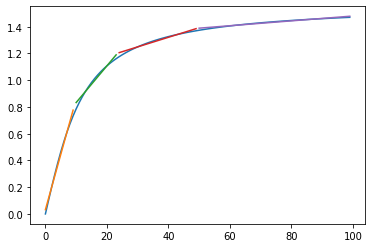

In [193]:
plt.plot(X, y)
for j in range(4):
    y_pred = k[j+1] * X[X_inds[:,j]] + b[j+1]
    plt.plot(X[X_inds[:,j]], y_pred)